# NYC Taxi Trip Duration - EDA

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy import distance

pd.set_option("display.float_format", "{:.2f}".format)

In [2]:
# Define constants
lib_loc = "/Users/nomic/Desktop/Nomi/develop/kiggle"

In [3]:
# Load the Data
train_data = pd.read_csv(lib_loc + '/data/train.csv')
test_data = pd.read_csv(lib_loc +'/data/test.csv')
train_df = train_data.copy() # Create a copy df that we will edit instead of the raw data

In [4]:
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98,40.77,-73.96,40.77,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98,40.74,-74.00,40.73,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.98,40.76,-74.01,40.71,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.01,40.72,-74.01,40.71,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.97,40.79,-73.97,40.78,N,435


In [6]:
test_data.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.99,40.73,-73.99,40.76,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.96,40.68,-73.96,40.66,N
2,id1217141,1,2016-06-30 23:59:47,1,-74.00,40.74,-73.99,40.73,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.96,40.77,-73.99,40.73,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.97,40.76,-73.96,40.76,N


In [7]:
# Summary Statistics
train_df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00
mean,1.53,1.66,-73.97,40.75,-73.97,40.75,959.49
std,0.50,1.31,0.07,0.03,0.07,0.04,5237.43
min,1.00,0.00,-121.93,34.36,-121.93,32.18,1.00
25%,1.00,1.00,-73.99,40.74,-73.99,40.74,397.00
50%,2.00,1.00,-73.98,40.75,-73.98,40.75,662.00
75%,2.00,2.00,-73.97,40.77,-73.96,40.77,1075.00
max,2.00,9.00,-61.34,51.88,-61.34,43.92,3526282.00


In [8]:
# Missing Values
train_df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [9]:
# Unique Values for each variable
train_df.nunique()

id                    1458644
vendor_id                   2
pickup_datetime       1380222
dropoff_datetime      1380377
passenger_count            10
pickup_longitude        23047
pickup_latitude         45245
dropoff_longitude       33821
dropoff_latitude        62519
store_and_fwd_flag          2
trip_duration            7417
dtype: int64

In [10]:
# Data Types
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [11]:
# Convert columnns to correct data types
train_df['vendor_id'] = train_df['vendor_id'].astype('category')
train_df['store_and_fwd_flag'] = train_df['store_and_fwd_flag'].astype('category')
train_df['pickup_datetime'] = pd.to_datetime(train_df['pickup_datetime'])
train_df['dropoff_datetime'] = pd.to_datetime(train_df['dropoff_datetime'])

Text(0.5, 1.0, 'Histogram of Log(Column)')

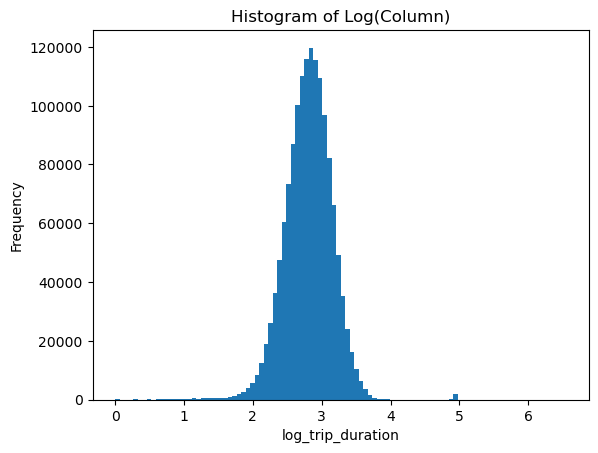

In [12]:
# Examine distribution of the target variable (trip duration)
# Plot the log of the duration since the distribution is skewed
plt.hist(np.log10(train_df['trip_duration']), bins = 100);
plt.xlabel('log_trip_duration')
plt.ylabel('Frequency')
plt.title('Histogram of Log(Column)')

In [13]:
# Check how many trips there are with unreasonably long/short durations
print(train_df.loc[train_df['trip_duration'] > 5*60*60, 'id'].count(), 'trips longer than 5 hours')
print(train_df.loc[train_df['trip_duration'] > 24*60*60, 'id'].count(), 'trips longer than 24 hours')
print(train_df.loc[train_df['trip_duration'] < 60, 'id'].count(), 'trips shorter than a minute')
# Most likely these values should be removed, but we'll keep them for now and look at the distances of these trips before deciding what to do with them

2072 trips longer than 5 hours
4 trips longer than 24 hours
8595 trips shorter than a minute


In [103]:
# look at number and duration of trips by vendor
train_df['vendor_id'].value_counts()

2    780302
1    678342
Name: vendor_id, dtype: int64

<Axes: xlabel='log_duration', ylabel='Count'>

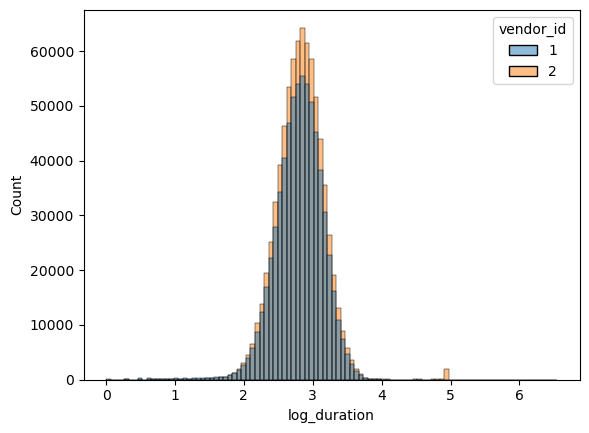

In [119]:
train_df['log_duration'] = np.log10(train_df['trip_duration'])
sns.histplot(data = train_df, x = 'log_duration', hue = 'vendor_id', bins = 100)

0         60
1    1033540
2     210318
3      59896
4      28404
5      78088
6      48333
7          3
8          1
9          1
Name: passenger_count, dtype: int64


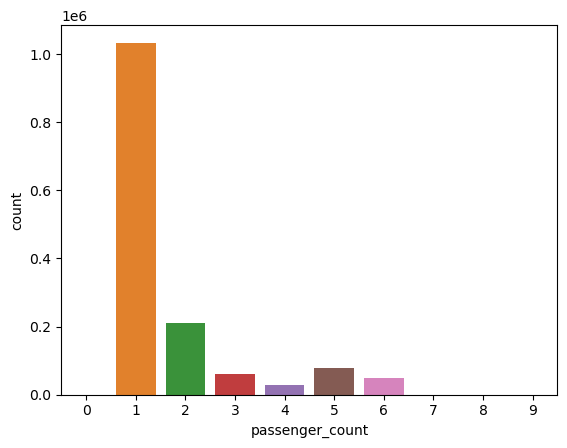

In [138]:
# Number and duration of trips by passenger number
sns.countplot(x=train_df['passenger_count'])
print(train_df['passenger_count'].value_counts().sort_index())

Text(0, 0.5, 'median trip duration (sec)')

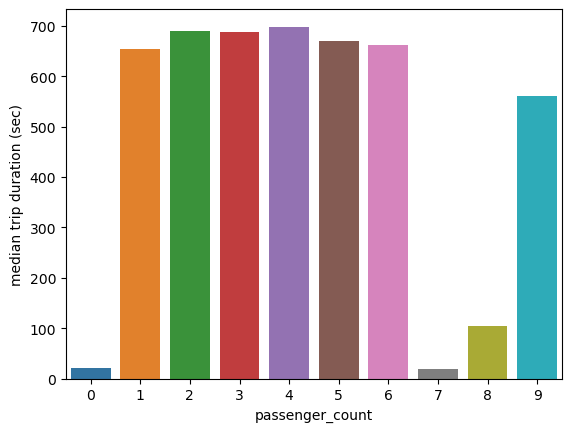

In [153]:
df = train_df.groupby('passenger_count')['trip_duration'].median().reset_index()
sns.barplot(x='passenger_count',y = 'trip_duration', data = df)
plt.ylabel('median trip duration (sec)')

## Effects of time on trip quantity & duration

In [100]:
# Create time & distance columns
train_df['day'] = train_df['pickup_datetime'].dt.day_name()
train_df['pickup_hour'] = train_df['pickup_datetime'].dt.hour
train_df['pickup_month'] = train_df['pickup_datetime'].dt.month
train_df['pickup_date'] = train_df['pickup_datetime'].dt.date
train_df['is_workday'] = train_df['pickup_datetime'].dt.dayofweek
train_df['is_workday'] = train_df['is_workday'] < 5

In [142]:
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,day,pickup_hour,log_duration,pickup_month,pickup_date,is_workday
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98,40.77,-73.96,40.77,N,455,Monday,17,2.66,3,2016-03-14,True
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98,40.74,-74.00,40.73,N,663,Sunday,0,2.82,6,2016-06-12,False
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.98,40.76,-74.01,40.71,N,2124,Tuesday,11,3.33,1,2016-01-19,True
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.01,40.72,-74.01,40.71,N,429,Wednesday,19,2.63,4,2016-04-06,True
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.97,40.79,-73.97,40.78,N,435,Saturday,13,2.64,3,2016-03-26,False


Text(0, 0.5, 'number of trips')

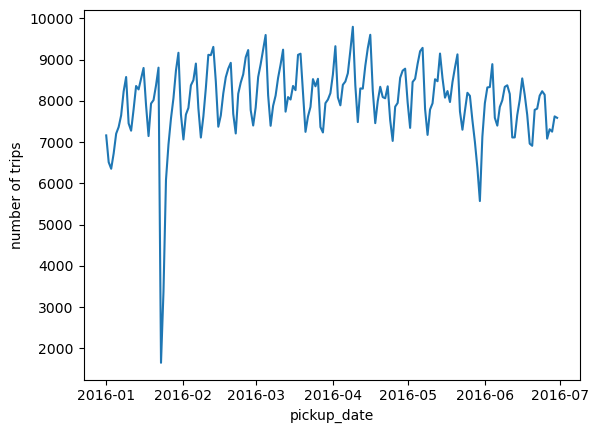

In [132]:
# plot the count of trips by date
count_trips_by_date = train_df.groupby('pickup_date')['id'].count()
sns.lineplot(data=count_trips_by_date)
plt.ylabel('number of trips')

Text(0, 0.5, 'number of trips')

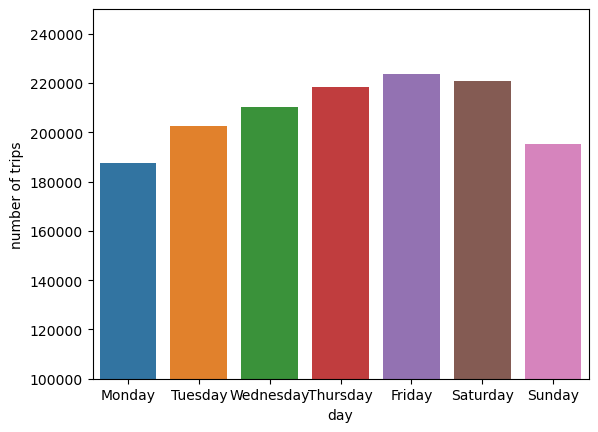

In [125]:
# Daily effects
sns.countplot(x=train_df['day'], order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.ylim(100000,250000)
plt.ylabel('number of trips')

Text(0, 0.5, 'median trip duration (sec)')

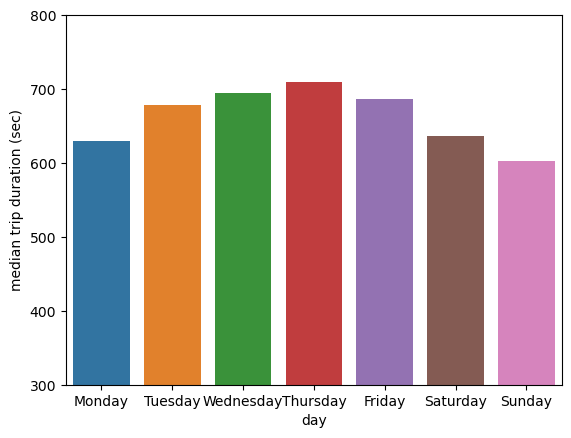

In [145]:
df = train_df.groupby('day')['trip_duration'].median().reset_index()
sns.barplot(x='day',y = 'trip_duration', data = df, order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.ylim(300,800)
plt.ylabel('median trip duration (sec)')

Text(0, 0.5, 'number of trips')

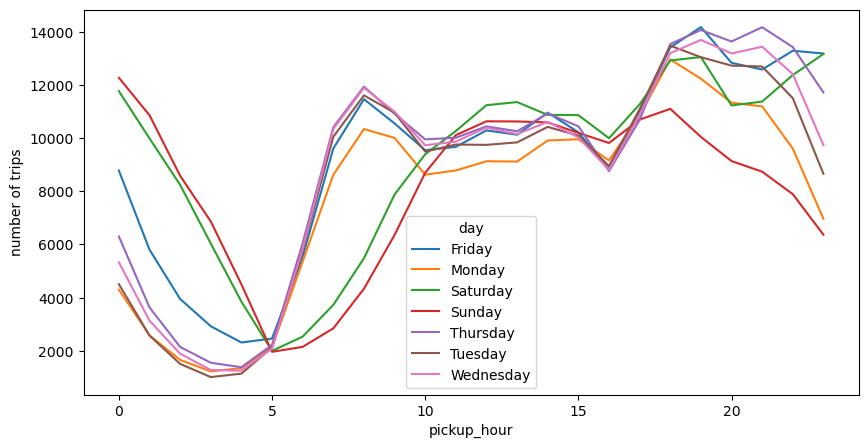

In [154]:
# effects by day and hour
fig, ax = plt.subplots(figsize=(10,5))
df = train_df.groupby(['day', 'pickup_hour'])['id'].count().reset_index()
sns.lineplot(ax = ax, data=df, x = 'pickup_hour', y = 'id', hue = 'day')
plt.ylabel('number of trips')